In [1]:
from importlib import reload
from tabulate import tabulate
from tqdm import tqdm_notebook as tqdm
import fairpol.predpol as fp
import fairpol.assesspol as ap
import fairpol.fairpol as ff
import itertools
import json
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import scipy as sp

In [2]:
from matplotlib import rc
rc('figure', **{ 'figsize': (14, 8) })
rc('font',**{ 'family': 'serif', 'serif': ['Palatino'] })
rc('font', **{ 'size': 20 })
rc('savefig', **{ 'bbox': 'tight', 'dpi': 150 })
rc('text', usetex=True)
rc('animation', html='jshtml')

In [3]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [4]:
gfx_dir = '../graphics/'

In [5]:
chicago = pd.read_csv('../data/ChicagoHomicides2012to2017.csv', parse_dates=['Date'])
train_idx = chicago.Year <= 2014
train = chicago.loc[train_idx]
test_idx = chicago.Year == 2015
test = chicago.loc[test_idx]

In [6]:
ill_demo = pd.read_csv('../data/Illinois2015CensusTractsDemographics.csv',
                    dtype={'tract': str, 'county': str}, index_col=0)

with open('../data/Illinois2015CensusTracts.json', 'r') as f:
    ill_shape = json.load(f)

In [7]:
try:
    print("Attempting to load saved results...")
    with open('../data/predpol_obj.p', 'rb') as f:
        pp = pickle.load(f)
except:
    print("Load failed. Re-computing results...")
    pp = fp.PredPol(train, grid_size=0.01)
    # pp.fit()
    # pp.omega, pp.sigma, pp.eta
    pp.omega, pp.sigma, pp.eta = (5.917576884767137, 0.0001143914018379195, 0.45282928154899593)
    pp.get_demographics(ill_shape, 'TRACTCE',
        ill_demo, 'tract', 'black', 'white',
        region_preprocess=lambda x: ''.join(x.split())
    )
    with open('../data/predpol_obj.p', 'wb') as f:
        pickle.dump(pp, f)
    print("Finished pickling results.")

Attempting to load saved results...


In [8]:
len(pp.grid_cells)

48475

In [9]:
pp.grid_cells.describe()

,x,y,black,white
count,48475.000000,48475.000000,39030.000000,39030.000000
mean,0.875000,1.385000,0.318088,0.681912
std,0.505178,0.799633,0.382855,0.382855
min,0.005000,0.005000,0.000000,0.000000
25%,0.435000,0.695000,0.025997,0.372543
50%,0.875000,1.385000,0.087865,0.912135
75%,1.315000,2.075000,0.627457,0.974003
max,1.745000,2.765000,1.000000,1.000000


# Accuracy Assessment

In [10]:
try:
    print("Attempting to load saved assessment...")
    with open('../data/assessment_daily_2015.p', 'rb') as f:
        assessment = pickle.load(f)
except:
    print("Load failed. Re-computing assessment...")
    assessment = ap.AssessPol(pp)
    days = sp.arange('2015-01-01', '2015-12-31', dtype='datetime64[D]')
    assessment.generate_predictions(chicago, days)
    with open('../data/assessment_daily_2015.p', 'wb') as f:
        pickle.dump(assessment, f)
    print("Finished pickling assessment.")

Attempting to load saved assessment...


In [11]:
fraction_flagged = sp.arange(0.0, 1.0, 1.0 / len(assessment.results))

In [12]:
assessment.get_predicted_intensities().describe()

,2015-01-01_lambda,2015-01-02_lambda,2015-01-03_lambda,2015-01-04_lambda,2015-01-05_lambda,2015-01-06_lambda,2015-01-07_lambda,2015-01-08_lambda,2015-01-09_lambda,2015-01-10_lambda,...,2015-12-21_lambda,2015-12-22_lambda,2015-12-23_lambda,2015-12-24_lambda,2015-12-25_lambda,2015-12-26_lambda,2015-12-27_lambda,2015-12-28_lambda,2015-12-29_lambda,2015-12-30_lambda
count,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,...,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000
mean,1241.277426,1241.277426,1241.277426,1241.661688,1241.661688,1242.060531,1243.008315,1243.008315,1243.421307,1243.821081,...,1404.456839,1405.106920,1405.106920,1405.749591,1406.307369,1406.639027,1407.330124,1408.221111,1408.511417,1408.781084
std,3532.796640,3532.796640,3532.796640,3532.850586,3532.850586,3532.896852,3533.272504,3533.272504,3533.432070,3533.518579,...,3595.551950,3595.705409,3595.705409,3595.993225,3596.163640,3596.269427,3596.492474,3596.919971,3596.944484,3597.100448
min,2.544970,2.544970,2.544970,2.544970,2.544970,2.579261,2.579289,2.579289,2.579289,2.579354,...,3.223379,3.223379,3.223379,3.223379,3.226267,3.226308,3.226308,3.229823,3.229823,3.229826
25%,192.005000,192.005000,192.005000,192.253414,192.253414,192.467427,192.542305,192.542305,192.714470,192.748225,...,267.236084,267.844961,267.844961,268.291825,268.517174,268.545912,268.846465,268.993073,269.387475,269.468367
50%,367.872178,367.872178,367.872178,368.165049,368.165049,368.537002,369.030560,369.030560,369.450883,369.639530,...,507.686076,508.498979,508.498979,509.107336,509.601104,509.766065,510.575686,511.224561,511.536621,511.731935
75%,603.082771,603.082771,603.082771,603.567138,603.567138,604.090354,605.272700,605.272700,605.765266,606.466820,...,826.236400,826.827606,826.827606,827.537089,828.485573,828.923085,829.897881,831.374841,831.601583,831.973016
max,73435.799144,73435.799144,73435.799144,73436.503115,73436.503115,73436.707380,73436.936952,73436.936952,73437.810695,73438.322627,...,74669.807949,74671.231700,74671.231700,74672.602825,74672.915626,74673.324781,74675.027156,74676.313142,74676.746301,74676.790800


In [13]:
assessment.get_actual_counts().values.sum(), len(test)

(502, 502)

In [14]:
accuracy = assessment.compute_accuracy()

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


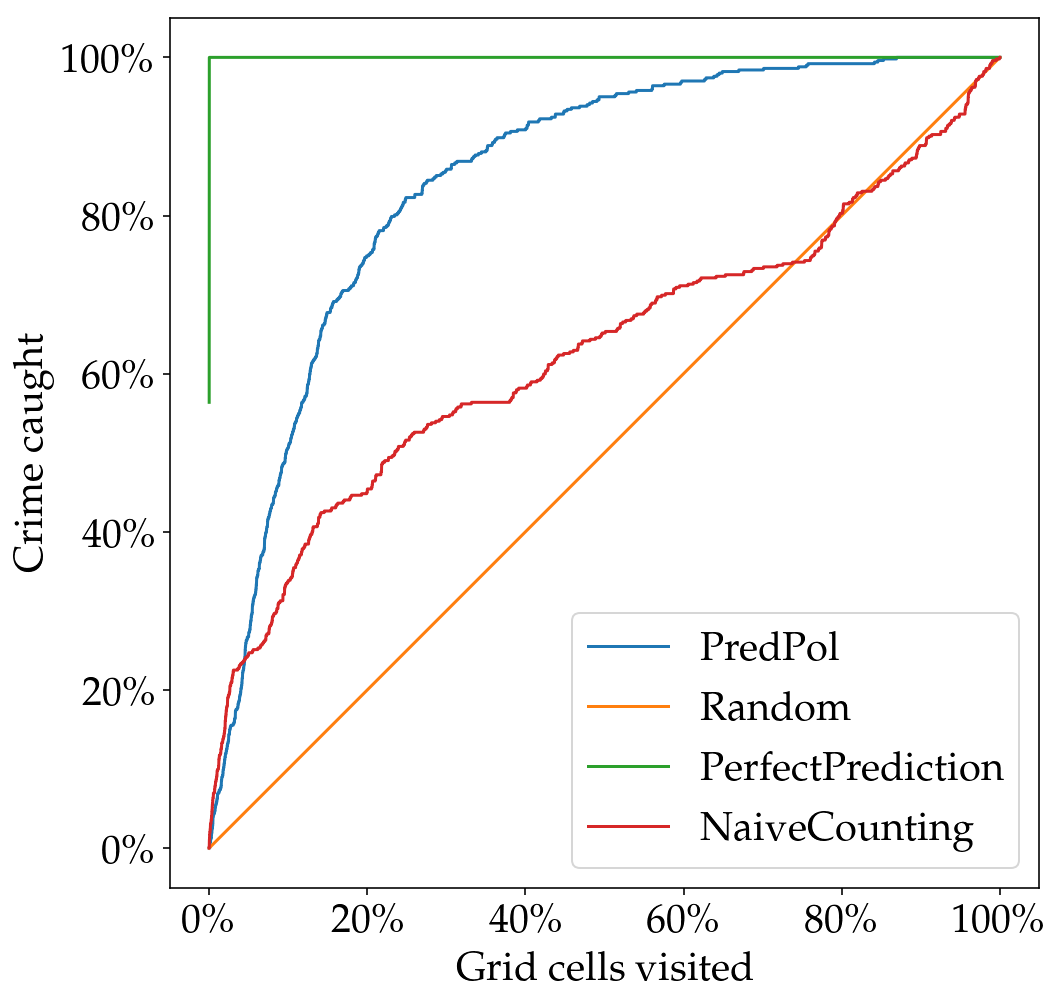

In [15]:
fig, ax = ap.plot_accuracy(accuracy)
ax.set_aspect('equal', adjustable='box')
plt.savefig(gfx_dir + 'AccuracyAll.png')
plt.show()

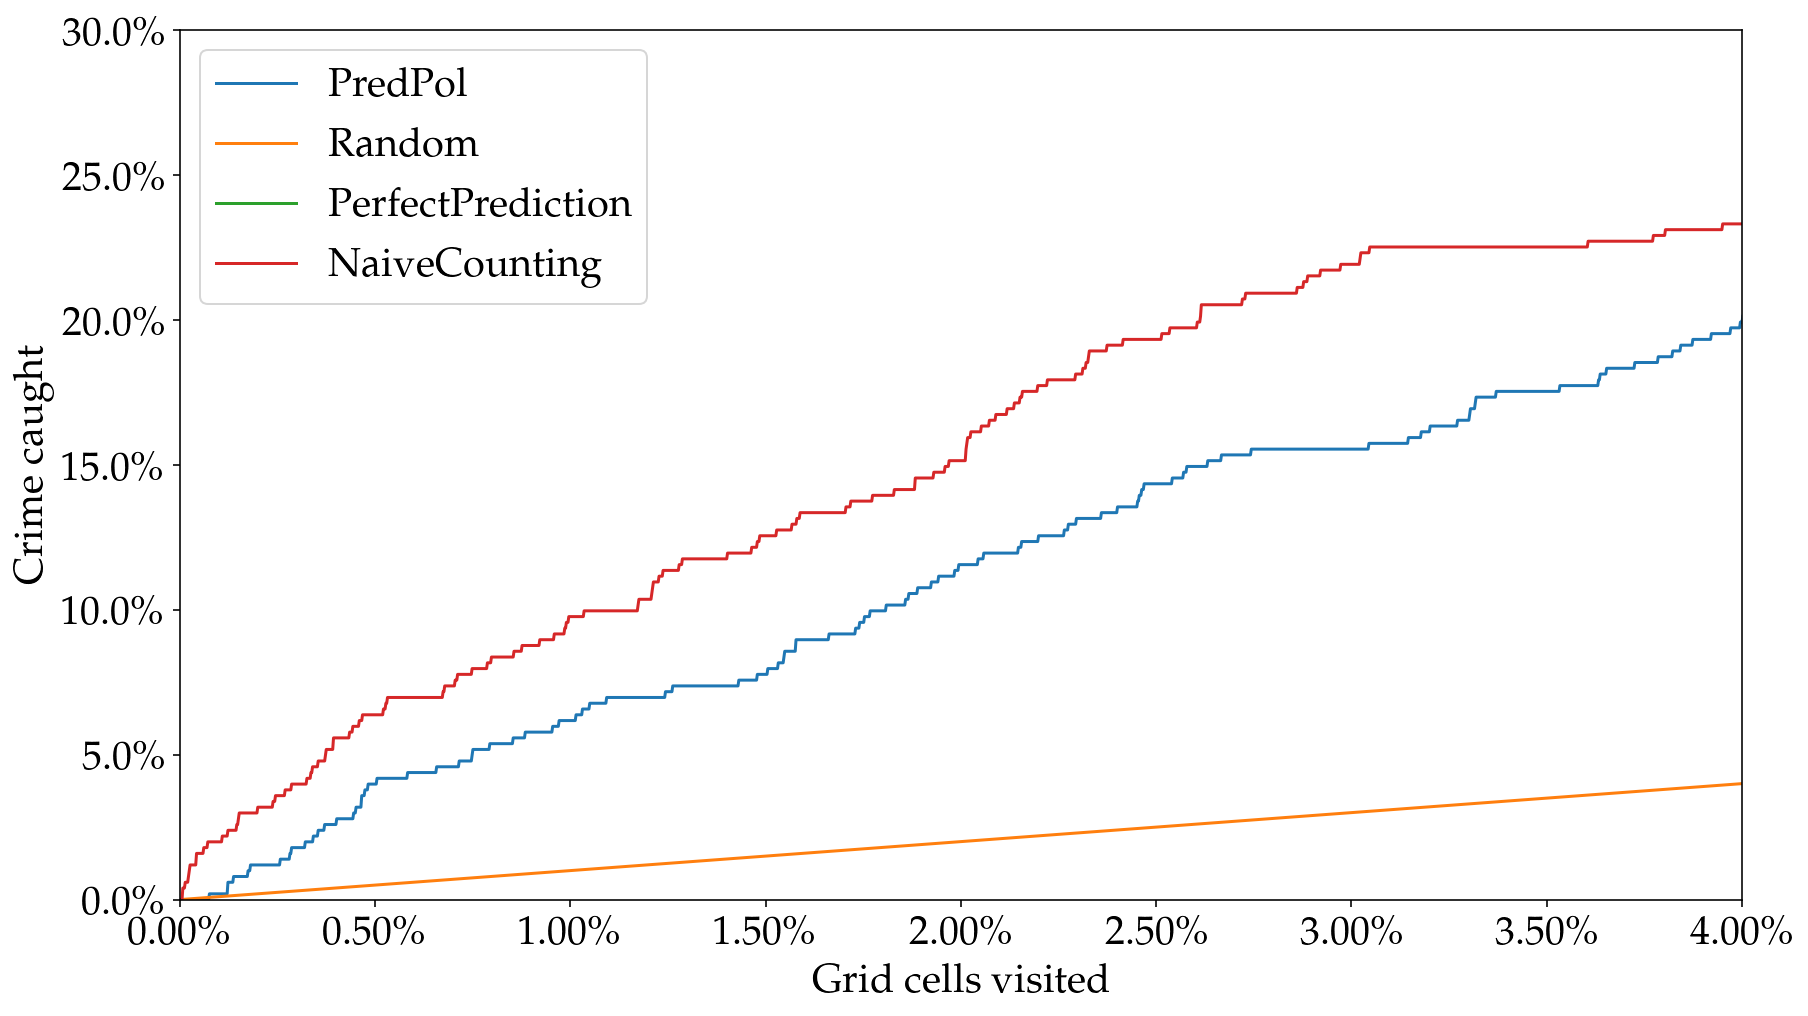

In [16]:
fig, ax = ap.plot_accuracy(accuracy)
ax.set(xlim=(0, 0.04), ylim=(0, 0.30))
plt.savefig(gfx_dir + 'AccuracyZoom.png')
plt.show()

# Fairness Assessment

In [17]:
fairness = assessment.compute_fairness()

/Users/mwyang/Dropbox/Minerva/2018-2019/CP194/src/fairpol/assesspol.py:103: RuntimeWarning: invalid value encountered in true_divide
  pct_black_caught /= sp.sum(pct_black_caught)
/Users/mwyang/Dropbox/Minerva/2018-2019/CP194/src/fairpol/assesspol.py:105: RuntimeWarning: invalid value encountered in true_divide
  pct_white_caught /= sp.sum(pct_white_caught)


In [18]:
fairness.describe()

,predpol,god,naive_count,random
count,4.847500e+04,4.847500e+04,48475.000000,48475.000000
mean,2.930337e-02,5.091029e-07,0.037843,-0.004451
std,2.392162e-02,8.210470e-05,0.018454,0.005077
min,-1.616534e-17,-2.607014e-03,-0.002164,-0.020891
25%,8.368541e-03,8.959561e-18,0.026501,-0.007356
50%,2.280350e-02,8.959561e-18,0.038142,-0.003864
75%,5.104986e-02,8.959561e-18,0.054126,-0.000711
max,7.883757e-02,1.566382e-02,0.068110,0.004783


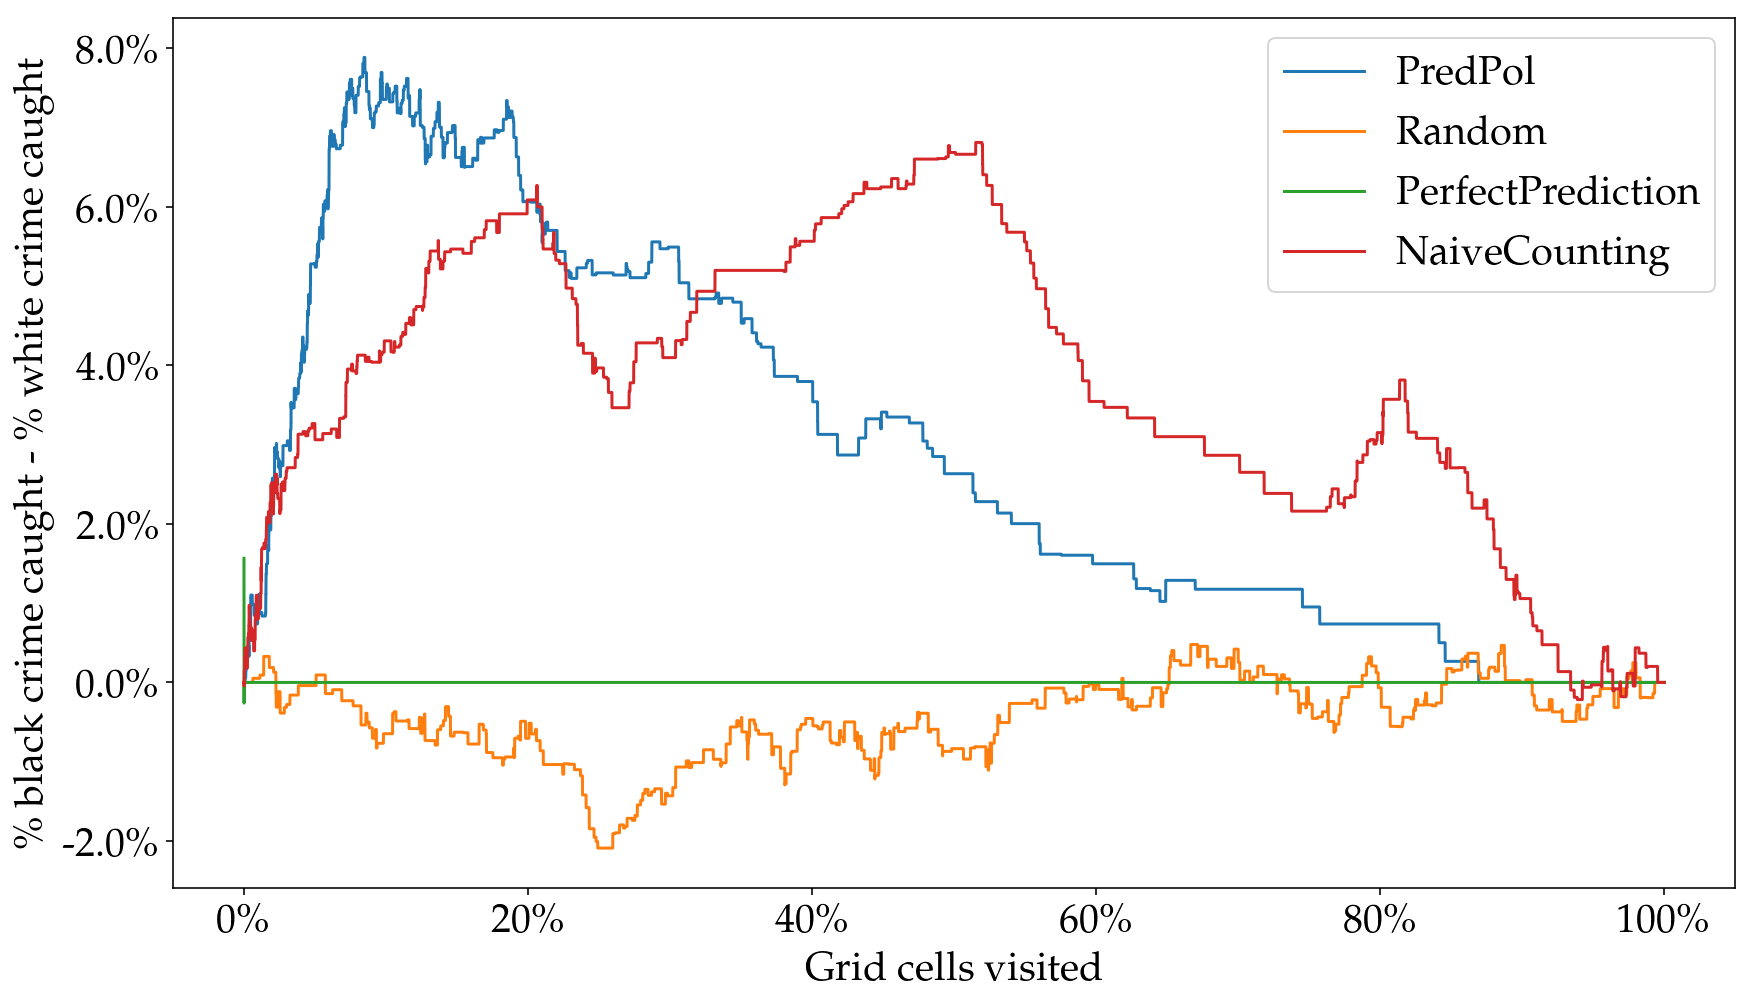

In [19]:
fig, ax = ap.plot_fairness(fairness)
plt.savefig(gfx_dir + 'FairnessAll.png')
plt.show()

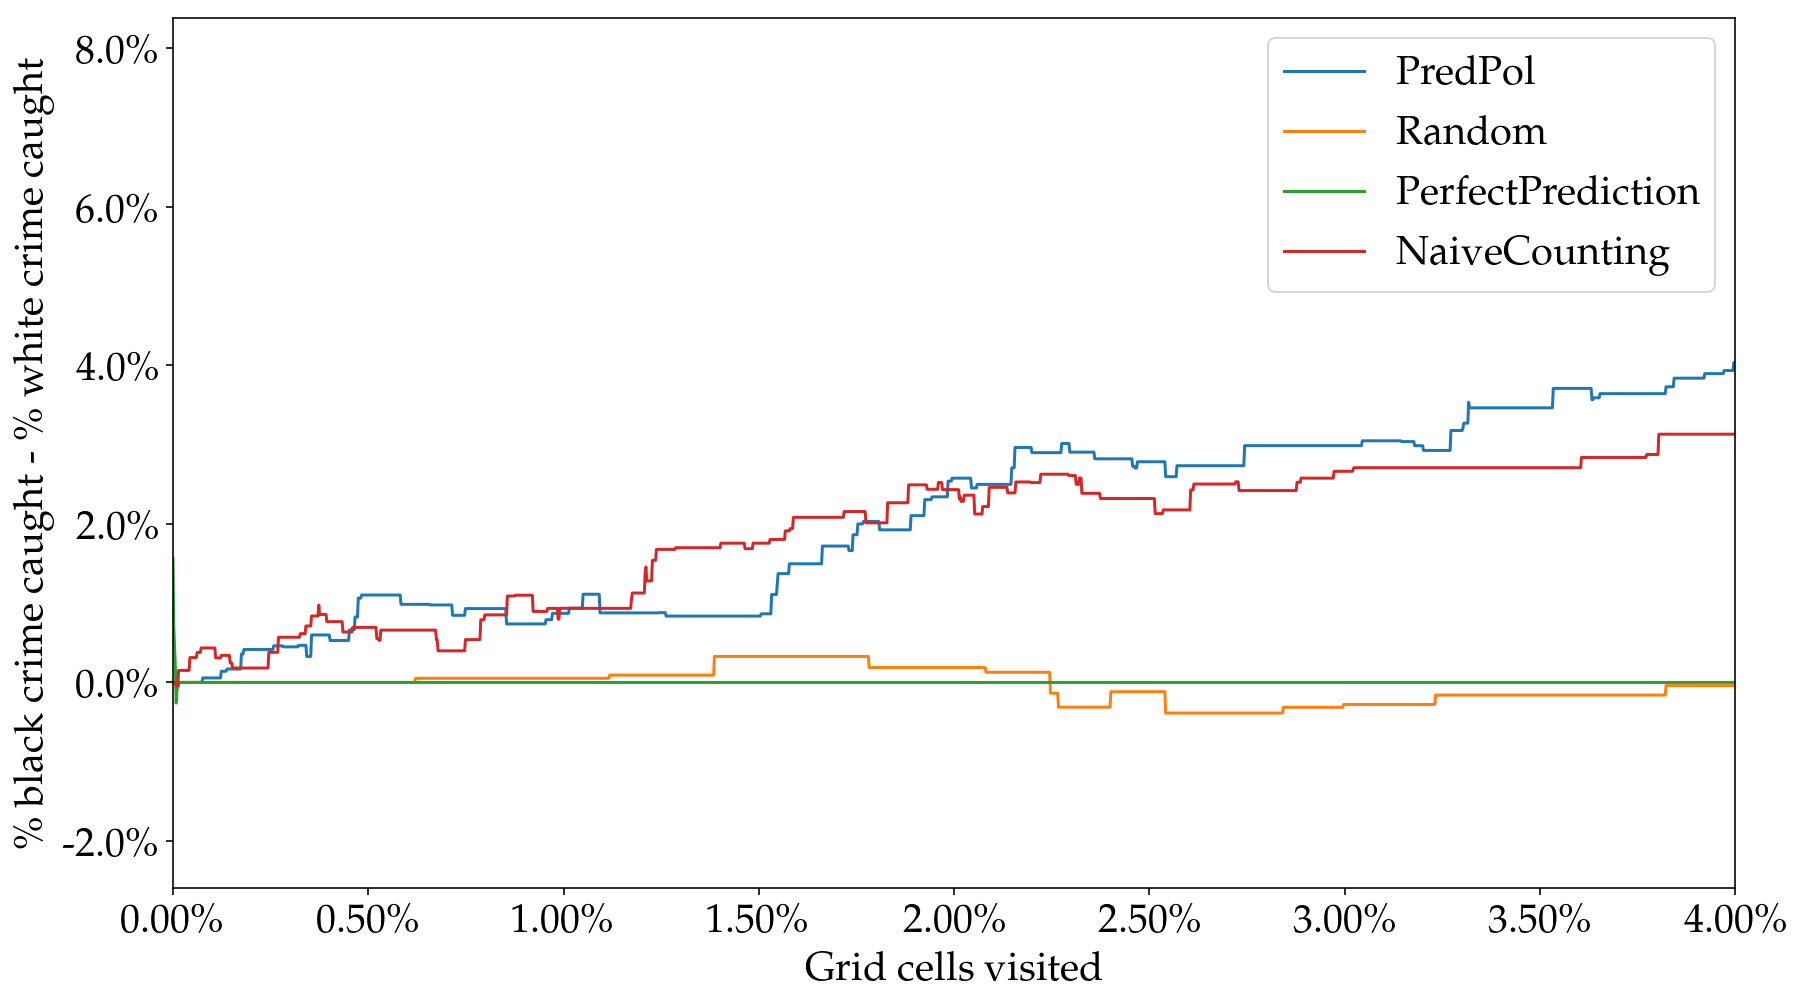

In [20]:
fig, ax = ap.plot_fairness(fairness)
ax.set(xlim=(0, 0.04))
plt.savefig(gfx_dir + 'FairnessZoom.png')
plt.show()

# Fairpol: Multi-Dimensional Knapsack

In [21]:
num_cells = sp.arange(100, 800, 100)
# num_cells = sp.arange(100, 2000, 100)
knapsack_items, knapsack_accuracy, knapsack_fairness = ff.compute_fp_knapsack(
    assessment, num_cells, total_cells_factor=2, max_gap=125
)
knapsack_accuracy, knapsack_fairness

/Users/mwyang/Dropbox/Minerva/2018-2019/CP194/src/fairpol/fairpol.py:48: RuntimeWarning: invalid value encountered in true_divide
  pct_black_caught /= sp.sum(pct_black_caught)
/Users/mwyang/Dropbox/Minerva/2018-2019/CP194/src/fairpol/fairpol.py:50: RuntimeWarning: invalid value encountered in true_divide
  pct_white_caught /= sp.sum(pct_white_caught)


(array([0.01195219, 0.02788845, 0.03784861, 0.04780876, 0.05577689,
        0.06374502, 0.07968127]),
 array([ 0.0041585 ,  0.00529126,  0.00087341, -0.00015778,  0.00339979,
         0.0044083 , -0.00043943]))

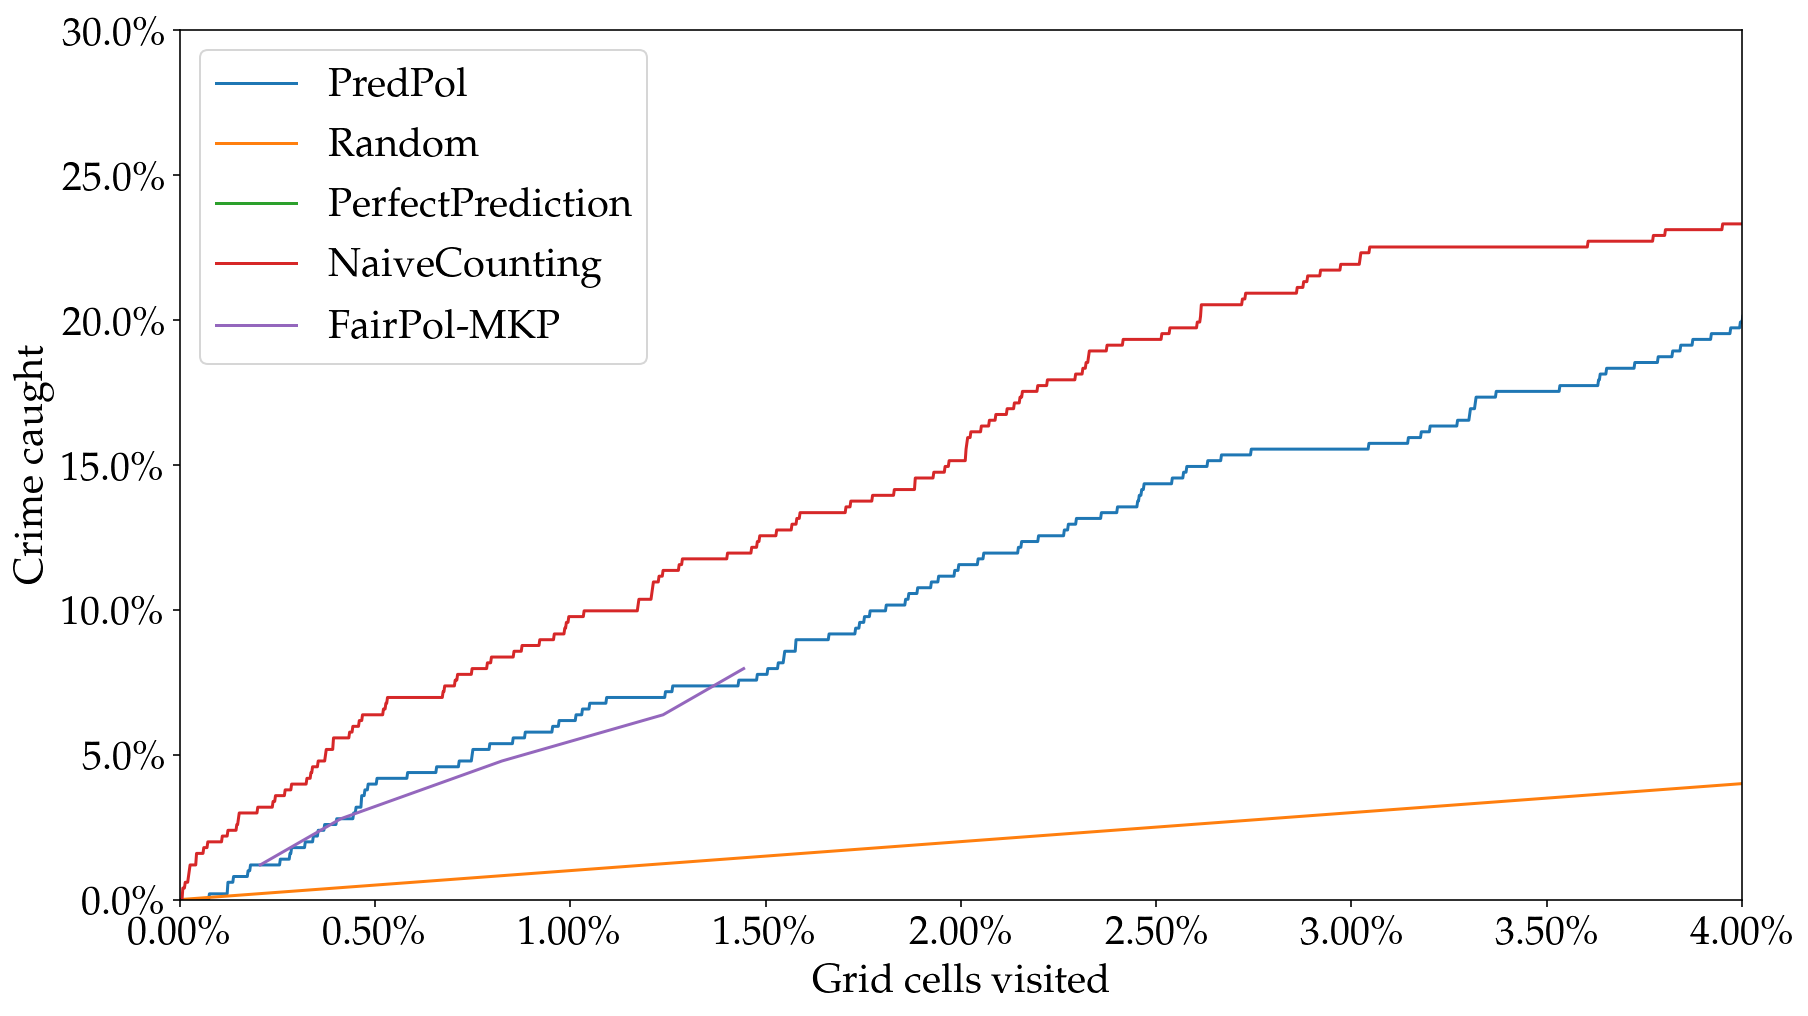

In [22]:
fig, ax = ap.plot_accuracy(accuracy)
ax.plot(num_cells / len(pp.grid_cells), knapsack_accuracy,
         label='FairPol-MKP')
ax.legend()
ax.set(xlim=(0, 0.04), ylim=(0, 0.30))
plt.savefig(gfx_dir + 'MKPAccuracy.png')
plt.show()

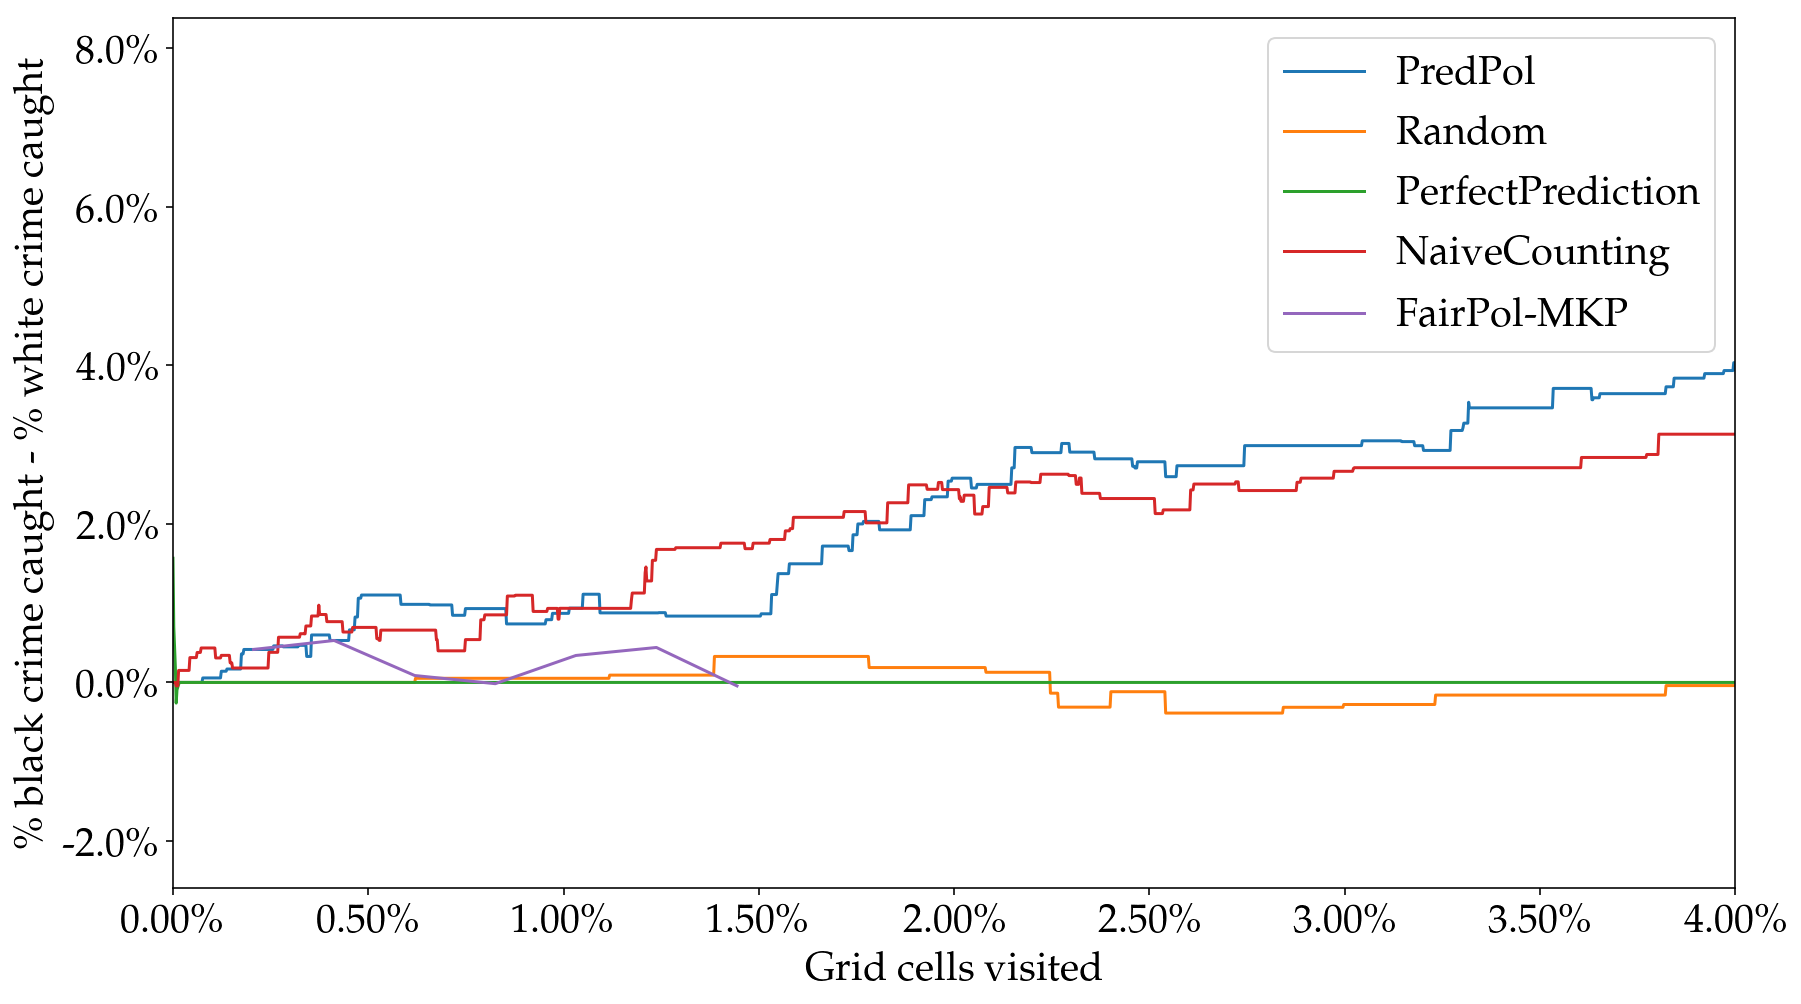

In [23]:
fig, ax = ap.plot_fairness(fairness)
ax.plot(num_cells / len(pp.grid_cells), knapsack_fairness,
         label='FairPol-MKP')
ax.legend()
ax.set(xlim=(0, 0.04))
plt.savefig(gfx_dir + 'MKPFairness.png')
plt.show()

# Fairpol: $\alpha$-Sorting

In [24]:
reload(fp)
reload(ap)
reload(ff)
print("Modules reloaded successfully.")

Modules reloaded successfully.


In [25]:
alphas = sp.arange(0.0, 1.0 + 1e-6, .01)
sorting_accuracy, sorting_fairness = ff.compute_fp_sorting(
    assessment, alphas=alphas
)
sorting_accuracy, sorting_fairness

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-6.61863726e-17, -3.20256642e-17, -5.18510753e-17, ...,
         -1.13767359e-16, -9.42469546e-17, -8.44867521e-17],
        [-6.61863726e-17, -3.20256642e-17, -5.18510753e-17, ...,
         -1.13767359e-16, -9.42469546e-17, -8.44867521e-17],
        [-6.61863726e-17, -3.20256642e-17, -5.18510753e-17, ...,
         -1.13767359e-16, -9.42469546e-17, 

In [26]:
colors = plt.cm.PRGn(sp.linspace(0, 1, len(alphas)))

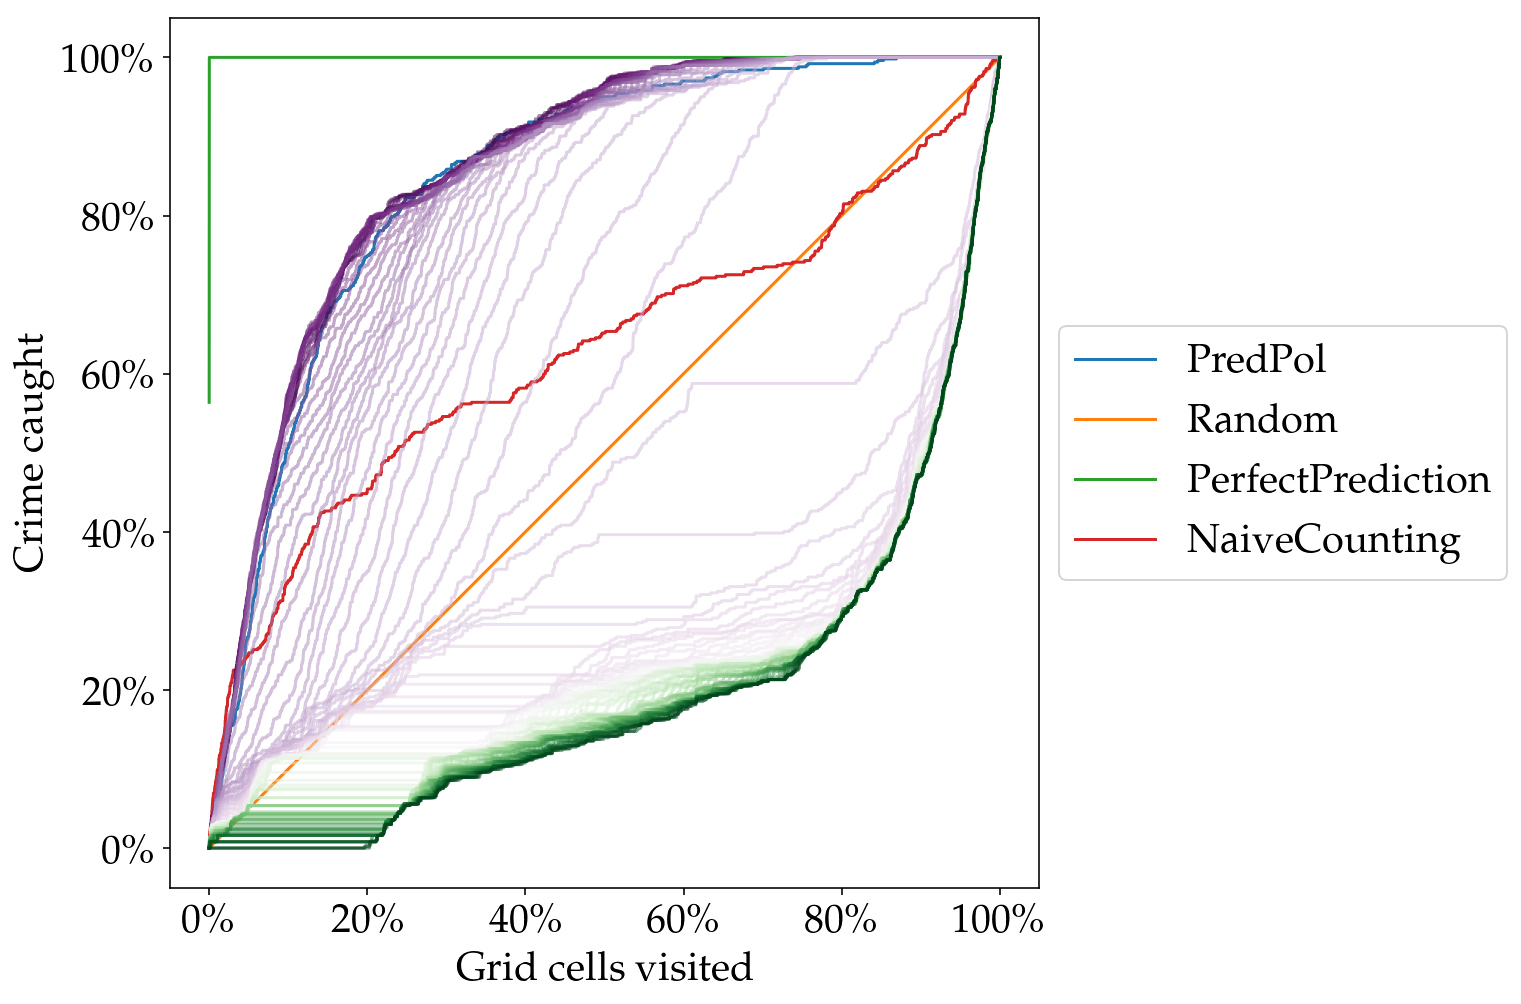

In [27]:
fig, ax = ap.plot_accuracy(accuracy)
for i, alpha in enumerate(alphas):
    ax.plot(fraction_flagged, sorting_accuracy[:, i],
            alpha=0.5, color=colors[i])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_aspect('equal', adjustable='box')
plt.savefig(gfx_dir + 'SortingAccuracyAll.png')
plt.show()

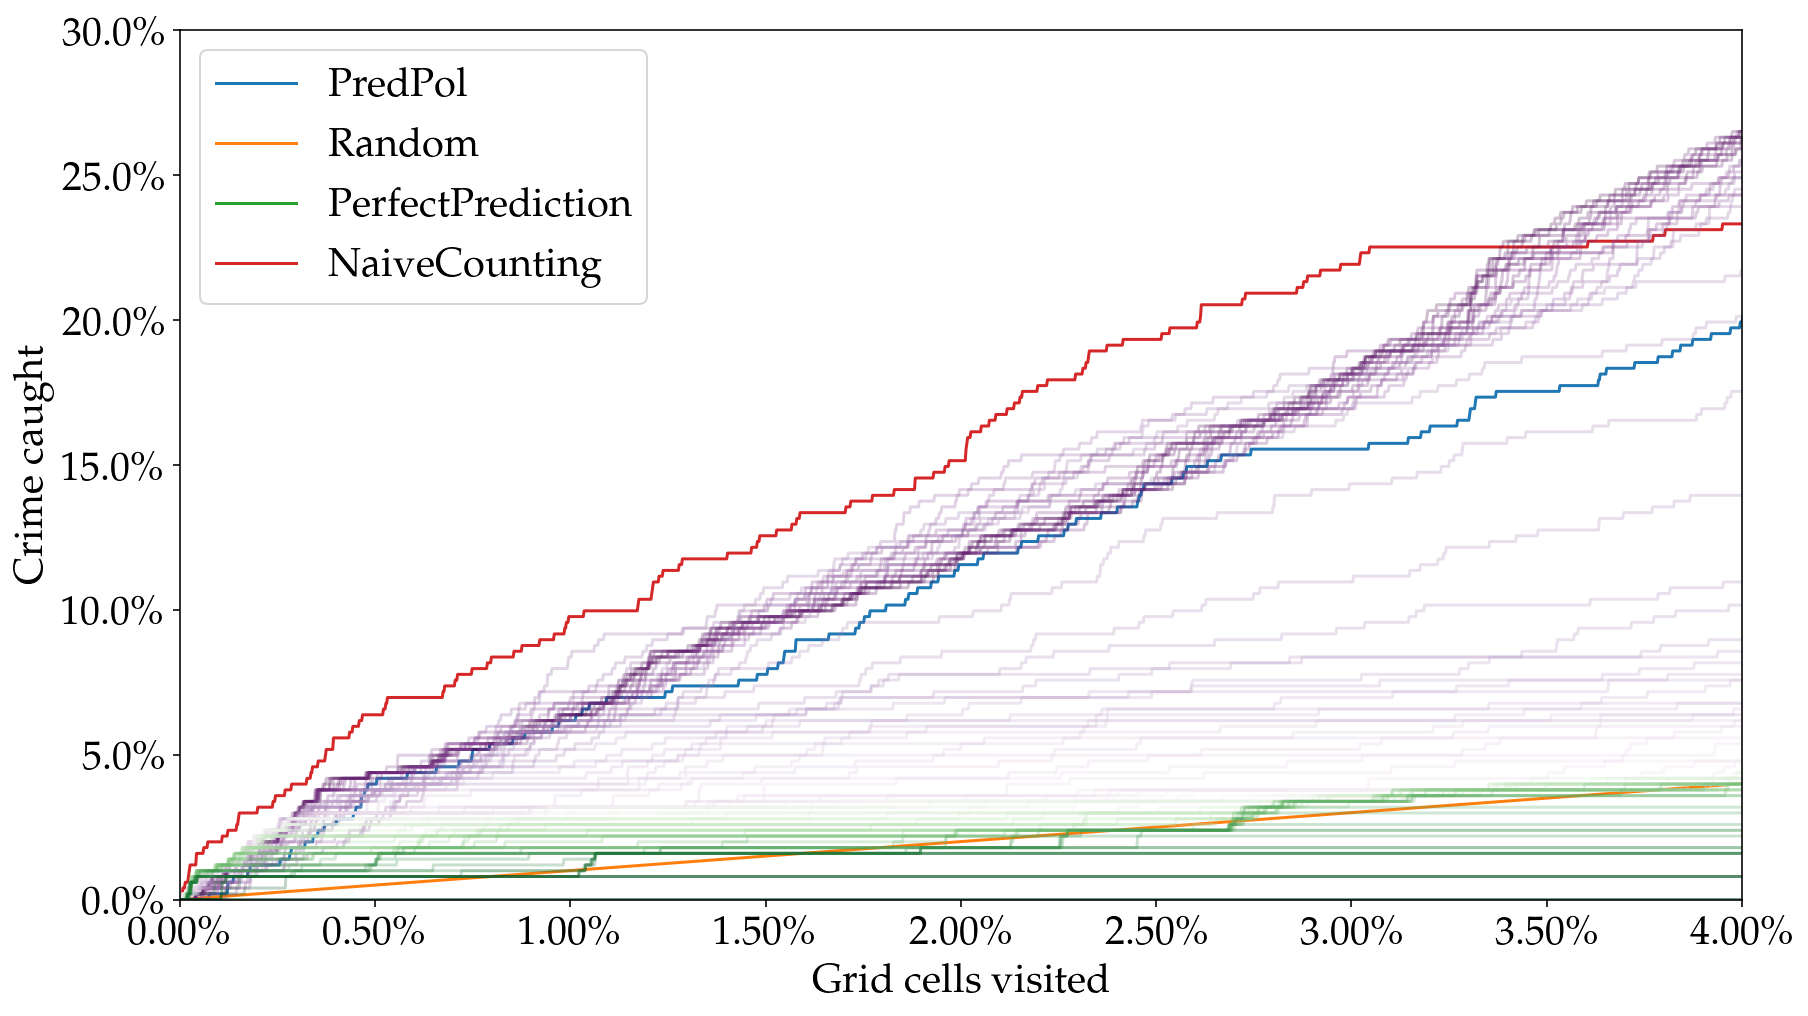

In [28]:
fig, ax = ap.plot_accuracy(accuracy)
for i, alpha in enumerate(alphas):
    ax.plot(fraction_flagged, sorting_accuracy[:, i],
            alpha=0.25, color=colors[i])
ax.set(xlim=(0, 0.04), ylim=(0, 0.30))
plt.savefig(gfx_dir + 'SortingAccuracyZoom.png')
plt.show()

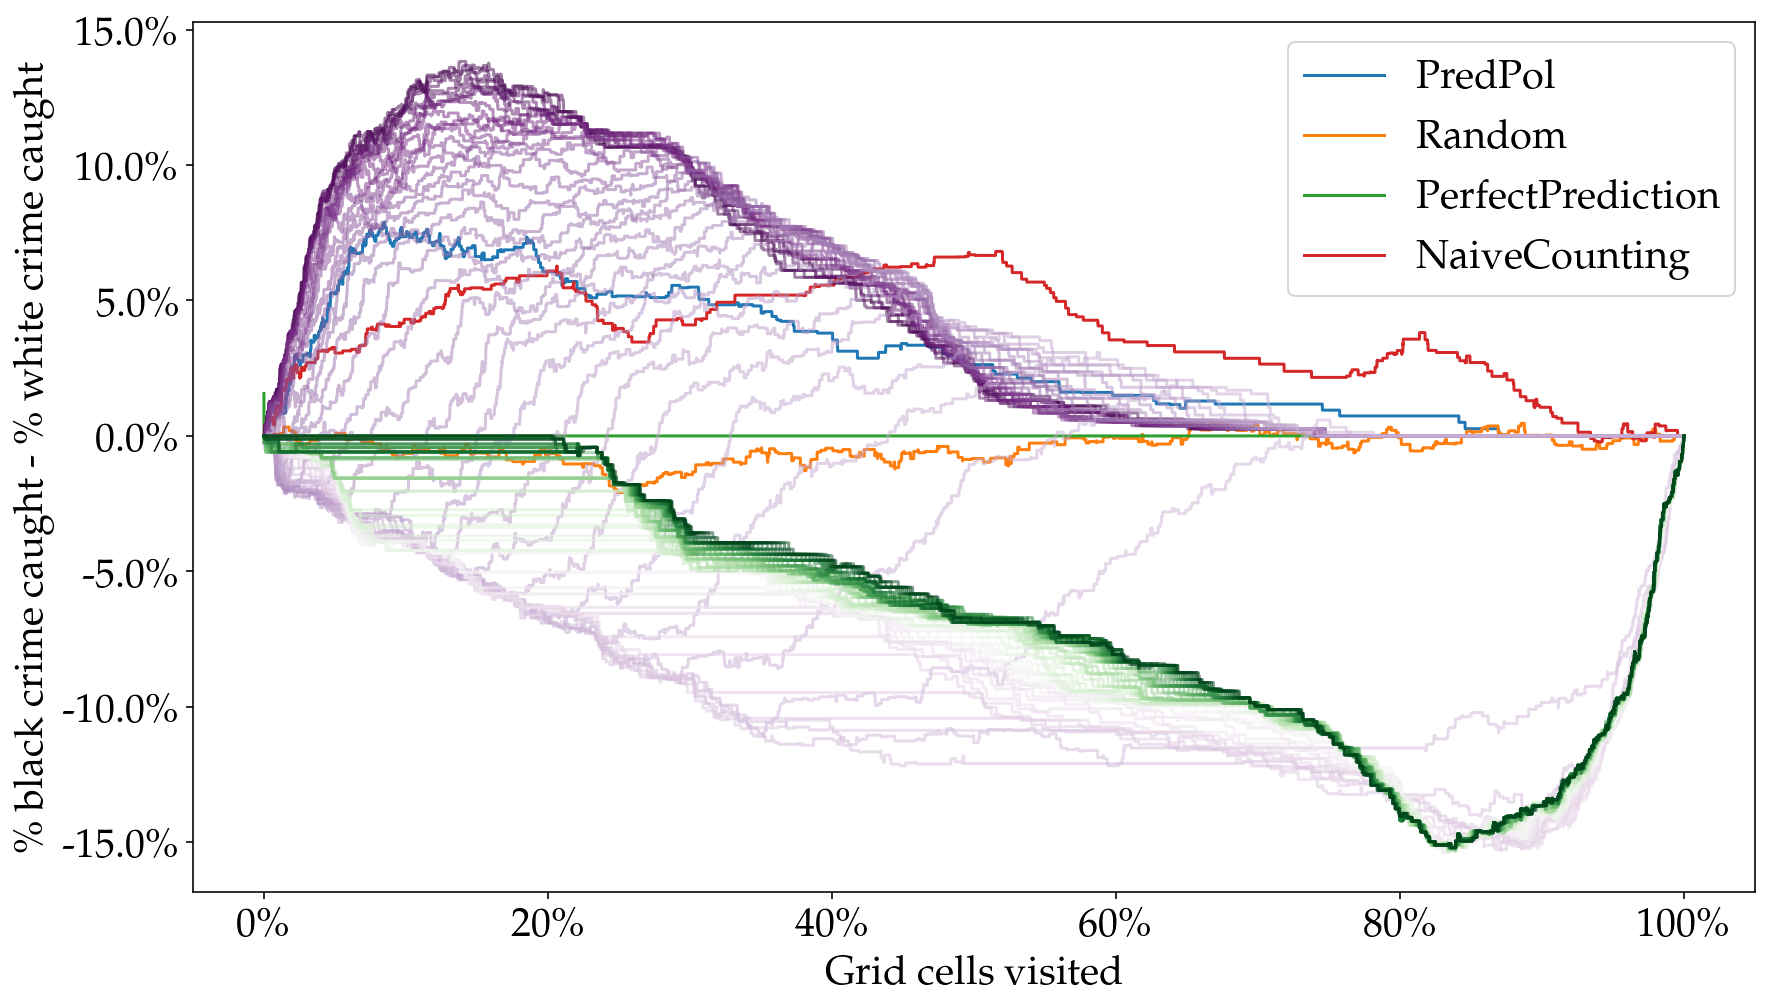

In [29]:
fig, ax = ap.plot_fairness(fairness)
for i, alpha in enumerate(alphas):
    ax.plot(fraction_flagged, sorting_fairness[:, i],
            alpha=0.5, color=colors[i], label=str(round(alpha, 2)))
plt.savefig(gfx_dir + 'SortingFairnessAll.png')
plt.show()

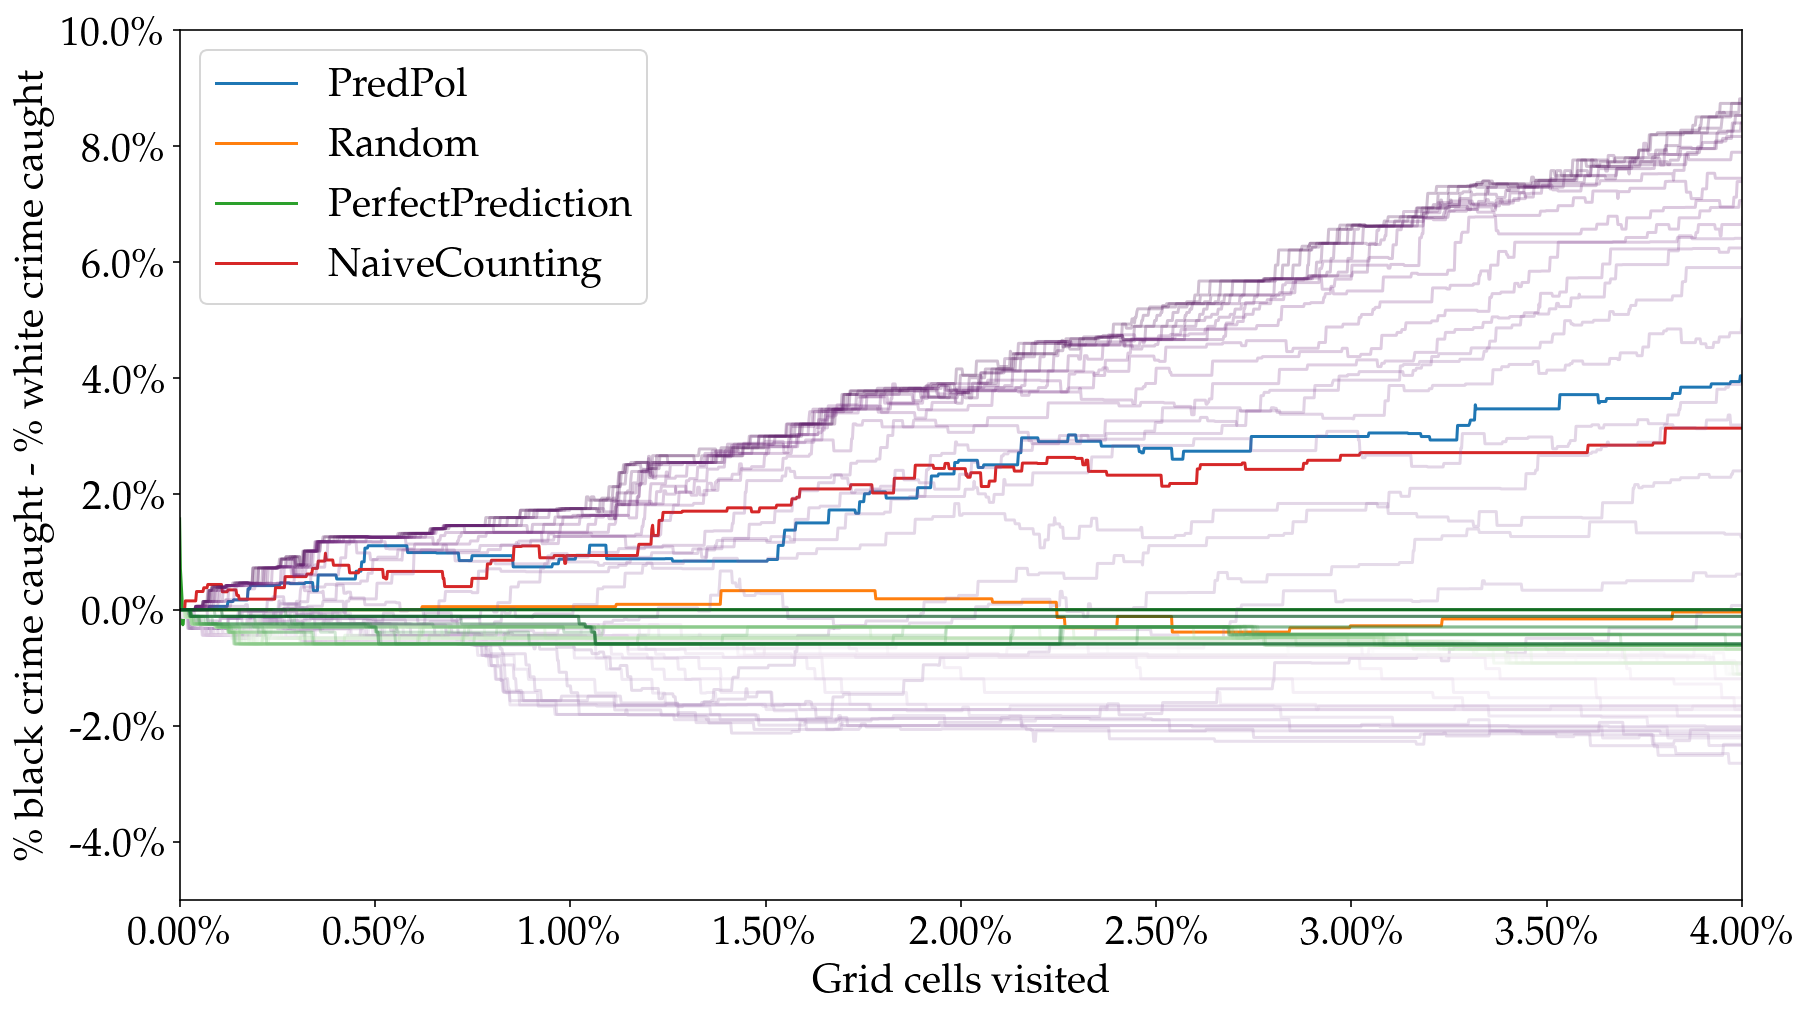

In [30]:
fig, ax = ap.plot_fairness(fairness)
for i, alpha in enumerate(alphas):
    ax.plot(fraction_flagged, sorting_fairness[:, i],
            alpha=0.25, color=colors[i], label=str(round(alpha, 2)))
ax.set(xlim=(0, 0.04), ylim=(-0.05, 0.10))
plt.savefig(gfx_dir + 'SortingFairnessZoom.png')
plt.show()